# Testing framework "pipeline"

_Alex Malz (NYU)_

In [1]:
import string
import itertools
import random
import numpy as np
import sklearn as skl
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import proclam
from proclam import *

## 1. True classes

Import the `proclam.Simulator` superclass and the simulator subclass you want to test.  In this notebook, I'm going to use an unbalanced distribution of true classes such that the probability of an object being in class $m$ (with $0 \leq m \leq M$) is proportional to $10^{y}$, where $y$ is a draw from a uniform distribution $U(0,M)$.

In [3]:
from proclam.simulators import simulator
from proclam.simulators import logunbalanced

Create an instantiation of the simulator for the true dataset class distribution scheme.  If you use the base superclass instead of a subclass, the default scheme will be to assign all objects the same class.

In [4]:
A = proclam.simulators.logunbalanced.LogUnbalanced()

Then, simulate a truth catalog.  In this case, there are 3 true classes and 100 objects in the catalog.  The output will be a `numpy.ndarray` with 100 entries, each of which is the index of the class for that catalog member.

In [5]:
A = proclam.simulators.logunbalanced.LogUnbalanced(seed=None)
M_classes = 3
N_objects = 1000
names = [''.join(random.sample(string.ascii_lowercase, 2)) for i in range(M_classes)]
truth = A.simulate(M_classes, N_objects)

We can check that the class distribution is as expected with a histogram of the true classes.

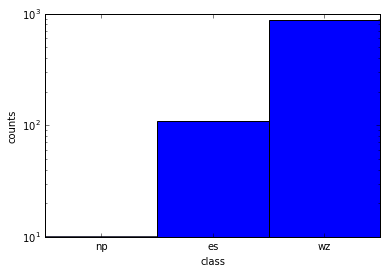

In [6]:
import numpy as np
d = np.diff(np.unique(truth)).min()
left_of_first_bin = truth.min() - float(d)/2
right_of_last_bin = truth.max() + float(d)/2
plt.hist(truth, np.arange(left_of_first_bin, right_of_last_bin + d, d),log=True)
plt.xticks(range(max(truth)+1), names)

#plt.hist(truth, log=True)
plt.ylabel('counts')
plt.xlabel('class')

## 2. Mock classifications

Import the `proclam.Classifier` superclass and the classifier subclass you want to test.  In this notebook, I'm going to use a very stupid classifier that takes a random guess.

In [7]:
from proclam.classifiers import classifier
from proclam.classifiers import guess
from proclam.classifiers import from_cm

Create an instantiation of the classifier of a particular scheme.  If you use the base superclass instead of a subclass, the default classification scheme will return the true classes.

Then, "classify" the "data."  By default, classification results will also include an extra column for "other" classes beyond the number in the training set, but in this example let's assume it knows of the 3 classes in the training set without leaving room for additional classes.  The output will be a `numpy.ndarray` with 100 rows and column entries representing each catalog member's posterior probability for being of each class.

In [8]:
B = proclam.classifiers.guess.Guess(seed=None)
predictionB = B.classify(3, truth, other=False)
# print(prediction)

Let's compare this to a smarter classifier based on a confusion matrix.

[[ 0.85147294  0.03737491  0.10297806]
 [ 0.12425126  0.79966572  0.08978748]
 [ 0.06661687  0.11628794  0.81535778]]


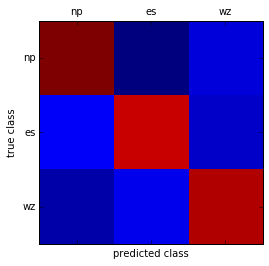

In [9]:
cm = np.eye(3) + 0.2 * np.random.uniform(size=(3, 3))
cm /= np.sum(cm, axis=1)
print(cm)
plt.matshow(cm)#, vmin=0., vmax=1.)
plt.xticks(range(max(truth)+1), names)
plt.yticks(range(max(truth)+1), names)
plt.xlabel('predicted class')
plt.ylabel('true class')

We want to support classifiers with an extra class for classes not represented in the training set, but the infrastructure isn't there yet.

In [12]:
C = proclam.classifiers.from_cm.FromCM(seed=None)
predictionC = C.classify(cm, truth, other=False)
print(predictionC)

[[ 0.08773872  0.24103121  0.67123008]
 [ 0.08002621  0.43233139  0.4876424 ]
 [ 0.06434508  0.12039901  0.81525591]
 ..., 
 [ 0.28662977  0.61622112  0.0971491 ]
 [ 0.08277892  0.12389271  0.79332838]
 [ 0.26341592  0.22136737  0.51521671]]


## 3. Metric values

Import the `proclam.Metric` superclass and the metric subclass you want to test.

In [13]:
from proclam.metrics import metric
from proclam.metrics import logloss
from proclam.metrics import brier

Let's try out the [logloss metric](https://en.wikipedia.org/wiki/Loss_functions_for_classification#Cross_entropy_loss).  The logloss metric is a sum over $LL_{ij} = -y_{ij}\ln[p_{ij}]$ for predicted probabilities $p$ and true class indicators $y$.

In [14]:
for candidate in [predictionB, predictionC]:
    D = proclam.metrics.logloss.LogLoss()
    performance = D.evaluate(candidate, truth, averaging='per_item')
    print('proclam implementation of log-loss: '+str(performance))

    alternative = skl.metrics.log_loss(truth, candidate, normalize=True)
    print('scikit-learn implementation of log-loss: '+str(alternative))

Averaging by per_item.
proclam implementation of log-loss: 1.3754396178
scikit-learn implementation of log-loss: 1.3754396178
Averaging by per_item.
proclam implementation of log-loss: 0.523267650684
scikit-learn implementation of log-loss: 0.523267650684


Let's try the [Brier score](https://en.wikipedia.org/wiki/Brier_score#Original_definition_by_Brier) this time.  The multi-class Brier score is $BS = \frac{1}{N}\sum\limits _{t=1}^{N}\sum\limits _{i=1}^{R}(f_{ti}-o_{ti})^2$ for $N$ objects, $R$ classes, predicted probabilities $f$, and $o_{i}$ of 1 for true class $i$ and 0 for other true classes.

First we create an instantiation of the metric.  Then, we calculate the metric value.  For binary classes, we can compare to the implementation in `scikit-learn`.

In [15]:
for candidate in [predictionB, predictionC]:
    E = proclam.metrics.brier.Brier()
    performance = E.evaluate(candidate, truth)
    print('proclam implementation of Brier score: '+str(performance))
    
    if M_classes == 2:
        skl_truth = proclam.metrics.util.truth_reformatter(truth).T[0]
        alternative = skl.metrics.brier_score_loss(skl_truth, prediction.T[0])
        print('scikit-learn implementation: '+str(alternative))

proclam implementation of Brier score: 0.260766880298
proclam implementation of Brier score: 0.0915784021797


# Next steps

Once there are more simulators, classifiers, and metrics, we'll loop over tests and plot comparisons.  Stay tuned for more!